<a href="https://colab.research.google.com/github/JaviPlou/Machine-learning-high-throughput-SERS-classification-of-cell-secretomes/blob/main/Machine_Learning_assisted_High_throughput_SERS_Classification_of_Cell_Secretomes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import csv
import matplotlib
import glob
import os
import itertools
!pip install tensorflow-addons
!pip install BaselineRemoval
from BaselineRemoval import BaselineRemoval

polynomial_degree=7 #only needed for Modpoly and IModPoly algorithm

# Librerias de ayuda
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
import joblib

matplotlib.style.use("seaborn-poster")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   
    if normalize:
        cw = cm.astype('int') / cm.sum(axis=1)[:, np.newaxis]
        pm = cm.astype("int")/cm.sum(axis=1)[:, np.newaxis]
        print(pm)
        data = np.around(pm, 2)
        plt.imshow(pm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        thresh = data.max() / 2.
        for i, j in itertools.product(range(data.shape[0]), range(data.shape[1])):
          plt.text(j, i, data[i, j],
          horizontalalignment="center",
          color="white" if data[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        print("Normalized confusion matrix")
    else:
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, cm[i, j],
          horizontalalignment="center",
          color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        print('Confusion matrix')

def graf(X,Y,color,ylims,ylimi,name):
  #Showing the SERS spectra
    t = 500
    s = 1500 
    plt.figure(figsize = [5,6])
    plt.plot(X, Y, color = color , linewidth=2)
    plt.axis( [t,s,ylims,ylimi])
    plt.title(name)
    plt.xticks( weight = "bold", style = "italic", fontsize = 8)
    plt.yticks([0,1], weight = "bold", fontsize = 8 )
    plt.xlabel("Raman  Wavenumber ",fontsize = 9,  horizontalalignment='center', weight = "bold", style = "italic")
    plt.ylabel('Intensity (A.U)', fontsize = 9,  horizontalalignment='center', weight = "bold", style = "italic")
    plt.savefig("/content/drive/My Drive/Colab Notebooks/Muertes/training"+name+".svg")



def live_dead(a):
  #To classify the SERS spectra as live/dead, it returns the prediction and the spectra
  try:
    a = a.split(",")
    r = a
  except:
    r = (a,)
  #List for wavenumer store
  Y = list()
  X = list()
  #DataFrame
  G = pd.DataFrame()
  #Open data text
  for i in r:
      x = i
      x = i.strip()
      colab = "/content/drive/My Drive/Colab Notebooks/Small/Manuscript/Datasets/"
      tabla = open(colab + x)
      volver = 0
      #Transform text into spectra
      for ii in tabla:
            datos = ii.split()
            if datos[0]== "#Wave":
                    continue
            f = datos[0]
            x0 = float(f)
            x0 = int(x0)
            if x0 > 450:   
              y = datos[1]
              y1 = float(y)
              Y.append(y1)
              X.append(x0)      
            if x0 > (1510):
              Ya = np.array(Y)
              #Baseline
              baseObj=BaselineRemoval(Ya)
              Modpoly_output=baseObj.ModPoly(polynomial_degree)
              Ya=baseObj.ModPoly(polynomial_degree)
              Y = (Ya-np.min(Ya))/np.ptp(Ya)
              Y = Y.transpose()
              #Graph
              graf(X,Y,"k",-1,2,x)
              G[x]= Y
              #Clear lists
              MM = X
              Y = list()
              X = list()
              break
      #Interpolate wavenumbers to match those used in the training of SVM
      G = G.set_index(pd.Index(MM))
      NN = np.load("/content/drive/My Drive/Colab Notebooks/Small/Manuscript/Datasets/wavenumber_training.npy")
      dmm = pd.DataFrame(G.columns)
      for j in NN:
          try:
            dmm[j]=np.array(G.loc[j])
          except:
            mean = (np.array(G.loc[j+1])+np.array(G.loc[j-1]))/2
            dmm[j]=np.array(mean)
        
      dmm = dmm.set_index(pd.Index(G.columns))
      dmm= dmm.drop(0, axis = 1)
      #Predictions by the SVM
      X_testh = dmm.values  
      svclassifier = joblib.load("/content/drive/My Drive/Colab Notebooks/Small/Manuscript/Datasets/svclassifier_L_D.pkl")
      y_pred = svclassifier.predict(X_testh) 
      for k in y_pred:
        if k == 0:
          print( i + "= LIVE")
        else:
          print(i+"= DEAD")
      G = pd.DataFrame()
      continue

    
    


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
#Dataset for the training
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Small/Manuscript/Datasets/SERS_spectra.csv",index_col=0)
df

,451,453,454,455,456,458,459,460,461,463,...,1501,1502,1503,1504,1505,1506,1507,1508,1509,1510
C9.txt0,0.929531,0.856761,0.770568,0.698466,0.629119,0.554608,0.449096,0.448342,0.378877,0.351141,...,0.154529,0.212262,0.223049,0.323476,0.247177,0.267240,0.219189,0.258922,0.276081,0.257088
C9.txt1,0.843681,0.822333,0.698393,0.631666,0.580854,0.512347,0.459354,0.400303,0.355963,0.375036,...,0.065243,0.031387,0.104098,0.159660,0.127358,0.081613,0.132936,0.175882,0.188674,0.192632
C9.txt2,0.668004,0.640560,0.595467,0.506612,0.466776,0.420169,0.402474,0.327908,0.291264,0.263045,...,0.332371,0.316275,0.330809,0.391089,0.386774,0.415643,0.421095,0.424623,0.454652,0.473108
C9.txt3,0.269168,0.237504,0.203287,0.214167,0.158721,0.148969,0.129846,0.121462,0.101469,0.099384,...,0.121592,0.144723,0.126842,0.164644,0.132508,0.185550,0.155216,0.116220,0.171338,0.187111
C9.txt4,0.884322,0.835997,0.749879,0.714337,0.626120,0.572328,0.519491,0.485756,0.418976,0.388879,...,0.215656,0.230513,0.221471,0.240211,0.260440,0.232885,0.233277,0.263528,0.299566,0.293447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hy_ 24h8.txt5493,0.164328,0.178267,0.180313,0.174832,0.154161,0.159873,0.143277,0.162380,0.134530,0.167577,...,0.096351,0.089522,0.108989,0.081479,0.105875,0.090066,0.091842,0.131982,0.117178,0.113247
Hy_ 24h8.txt5494,0.179129,0.174232,0.182560,0.149447,0.154513,0.144274,0.162723,0.165864,0.167369,0.130348,...,0.141767,0.134456,0.156413,0.165532,0.154091,0.136159,0.140220,0.176699,0.165598,0.181629
Hy_ 24h8.txt5495,0.147007,0.145934,0.146664,0.170008,0.164486,0.154735,0.145682,0.144453,0.157080,0.149025,...,0.131095,0.098400,0.100075,0.157600,0.121110,0.139208,0.145963,0.209948,0.180534,0.165350
Hy_ 24h8.txt5496,0.110239,0.126625,0.140050,0.148665,0.143841,0.124338,0.143143,0.151583,0.112666,0.162628,...,0.115798,0.101491,0.111454,0.145825,0.124182,0.148773,0.093218,0.160477,0.183824,0.193632


# **LABELING**

In [19]:
#Labeling with LDH readouts
df_categories = pd.DataFrame(df.index)
df_categories[df_categories[0].str.contains("C")] = 'live cells'
df_categories[df_categories[0].str.contains("UV_1h")] = 'live cells'
df_categories[df_categories[0].str.contains("UV")] = 'dead cells'
df_categories[df_categories[0].str.contains("Hy")] = 'dead cells'
df_categories[df_categories[0].str.contains("T")] = 'dead cells'

dic = {"live cells":int(0),
       "dead cells":int(1)}
  
df_categories ["ID"] = df_categories[0].map(dic)
df_categories

,0,ID
0,live cells,0
1,live cells,0
2,live cells,0
3,live cells,0
4,live cells,0
...,...,...
5493,dead cells,1
5494,dead cells,1
5495,dead cells,1
5496,dead cells,1


In [20]:
X_total = df.values
y_total = df_categories['ID'].values

In [21]:
#Data spliting (70-30)
X_train, X_val, y_train, y_val = train_test_split(X_total, y_total, random_state=104, test_size=0.30, shuffle=True)

# **SVM** TRAINING AND VALIDATION (LIVE & DEAD)


[[0.95 0.05]
 [0.03 0.97]]
Normalized confusion matrix


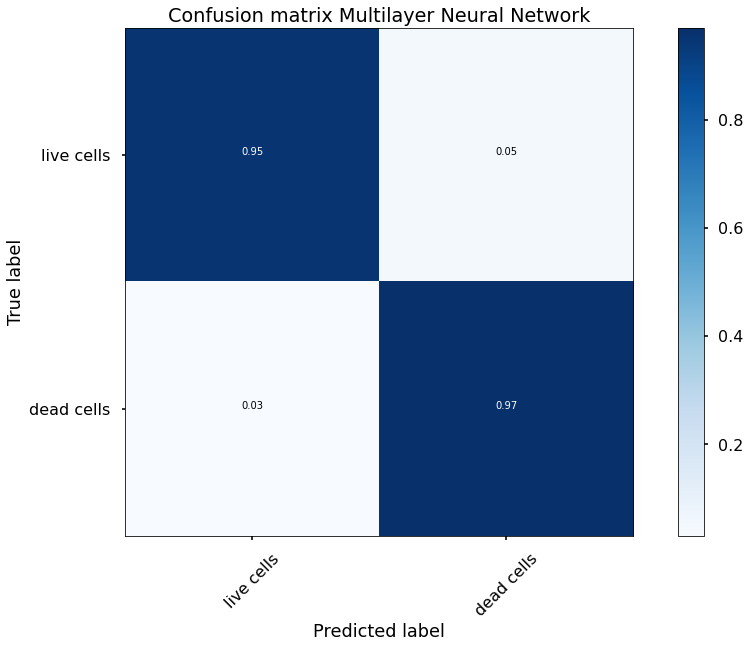

In [22]:
# Training the SVM model
svclassifier = SVC(kernel="linear")
svclassifier.fit(X_train, y_train)
joblib.dump(svclassifier, "/content/drive/My Drive/Colab Notebooks/Small/Manuscript/Datasets/svclassifier_L_D.pkl")
y_pred = svclassifier.predict(X_val)
cnf_matrix = sklearn.metrics.confusion_matrix(y_val,y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['live cells', 'dead cells'], title='Confusion matrix Multilayer Neural Network',normalize=True)

# **TESTING** LIVE & DEAD

In [23]:
#Dataset for testing with n=20
dc = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Small/Manuscript/Datasets/SERS_testing.csv",index_col=0)
dc

,451,453,454,455,456,458,459,460,461,463,...,1501,1502,1503,1504,1505,1506,1507,1508,1509,1510
Stau_1.txt,0.392634,0.383278,0.378453,0.361311,0.330482,0.333418,0.334848,0.322981,0.308126,0.303978,...,0.200542,0.204194,0.188855,0.206483,0.197102,0.171607,0.173293,0.196096,0.179072,0.154636
C1_16h.txt,0.290520,0.290969,0.276448,0.261548,0.260037,0.243139,0.245394,0.227718,0.227853,0.227118,...,0.258400,0.249946,0.259921,0.282722,0.283377,0.273370,0.258039,0.295418,0.300898,0.305647
C2_16h.txt,0.390007,0.375865,0.372730,0.353749,0.327176,0.322816,0.317241,0.304859,0.296032,0.286601,...,0.208587,0.209063,0.206424,0.242912,0.220052,0.217043,0.229410,0.249292,0.249380,0.241495
Rapamycin_1.txt,0.288929,0.292278,0.288612,0.275582,0.270088,0.256242,0.249272,0.249004,0.238044,0.236184,...,0.198615,0.198454,0.201520,0.233993,0.242709,0.245713,0.235615,0.266554,0.279260,0.279201
C1.txt,0.433746,0.419860,0.404181,0.397215,0.378278,0.376481,0.374879,0.370324,0.347678,0.338041,...,0.299325,0.278900,0.266913,0.294019,0.287000,0.292221,0.270987,0.296658,0.301945,0.302783
Stau_2.txt,0.444372,0.426622,0.405723,0.406901,0.393568,0.375818,0.393671,0.357923,0.362825,0.338272,...,0.237843,0.234089,0.240229,0.254684,0.257591,0.247580,0.231983,0.241109,0.236038,0.231303
Stau_3.txt,0.378799,0.384276,0.362850,0.369106,0.336097,0.348674,0.337067,0.342904,0.337426,0.310507,...,0.339570,0.339644,0.336752,0.370448,0.341254,0.308208,0.303193,0.321387,0.291578,0.291732
H202_1.txt,0.945212,0.884338,0.815891,0.747318,0.684744,0.618831,0.564641,0.530639,0.489114,0.454413,...,0.051331,0.054344,0.054589,0.066778,0.060676,0.045279,0.039120,0.038503,0.036826,0.036266
H202_2.txt,0.729560,0.711254,0.681848,0.654075,0.619777,0.585628,0.556396,0.534405,0.517197,0.503754,...,0.076521,0.072800,0.066549,0.076727,0.063894,0.048957,0.030783,0.027781,0.017765,0.018224
H202_3.txt,0.452436,0.438197,0.424210,0.407639,0.391171,0.371127,0.351366,0.339005,0.324834,0.317027,...,0.030525,0.030205,0.028838,0.035818,0.029945,0.024960,0.021896,0.022473,0.017481,0.017073


In [24]:
#Labeling with LDH readouts
dc_categories = pd.DataFrame(dc.index)

dc_categories[dc_categories[0].str.contains("C")] = 'live cells'
dc_categories[dc_categories[0].str.contains("Ra")] = 'live cells'
dc_categories[dc_categories[0].str.contains("H2")] = 'dead cells'
dc_categories[dc_categories[0].str.contains("S")] = 'dead cells'

dic = {"live cells":0,
       "dead cells":1}
  
dc_categories ["ID"] = dc_categories[0].map(dic)
X_test = dc.values
y_te= dc_categories['ID'].values

Confusion matrix


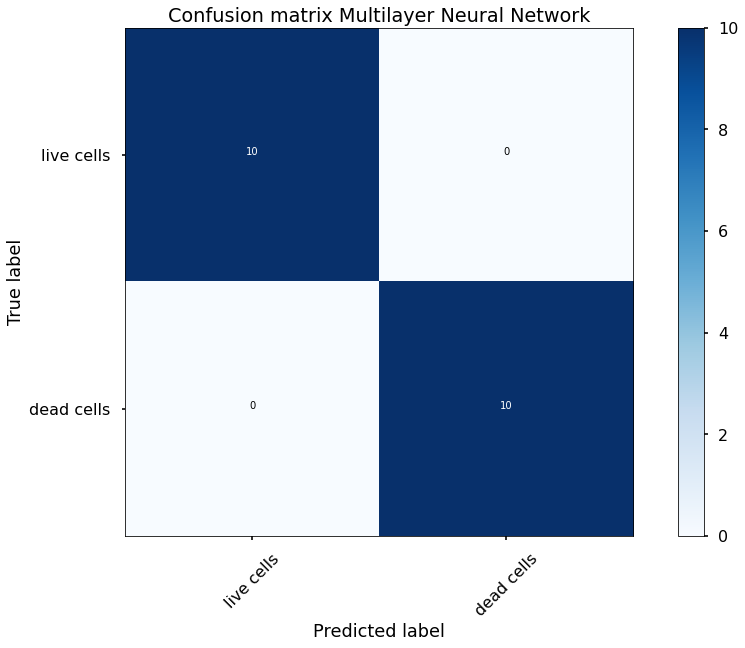

In [25]:
#Testing the model with new conditions 
y_pred = svclassifier.predict(X_test)
cnf_matrix = sklearn.metrics.confusion_matrix(y_te,y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['live cells', 'dead cells'], title='Confusion matrix Multilayer Neural Network')
plt.savefig("/content/drive/My Drive/Colab Notebooks/Muertes/training_confussionsvm.svg")

# **SVM** TRAINING AND VALIDATION (NECROSIS & APOPTOSIS)


In [26]:
#Labeling of the dataset with flow cytometry outputs
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Small/Manuscript/Datasets/SERS_spectra.csv",index_col=0)
df_categories = pd.DataFrame(df.index)
df_categories[df_categories[0].str.contains("C")] = 'live cells'
df_categories[df_categories[0].str.contains("UV_1h")] = "live cells"
df_categories[df_categories[0].str.contains("UV")] = 'apoptosis'
df_categories[df_categories[0].str.contains("Hy")] = 'necrosis'
df_categories[df_categories[0].str.contains("T")] = 'necrosis'

dic2 = {"live cells":0,
       "necrosis":1,
        "apoptosis":2}
  
df_categories ["ID"] = df_categories[0].map(dic2)

In [27]:
X_total = df.values
y_total = df_categories['ID'].values

In [28]:
#Spliting(70-30)
X_train, X_val, y_train, y_val = train_test_split(X_total, y_total, random_state=104, test_size=0.30, shuffle=True)

[[0.95 0.01 0.04]
 [0.02 0.96 0.02]
 [0.08 0.01 0.91]]
Normalized confusion matrix


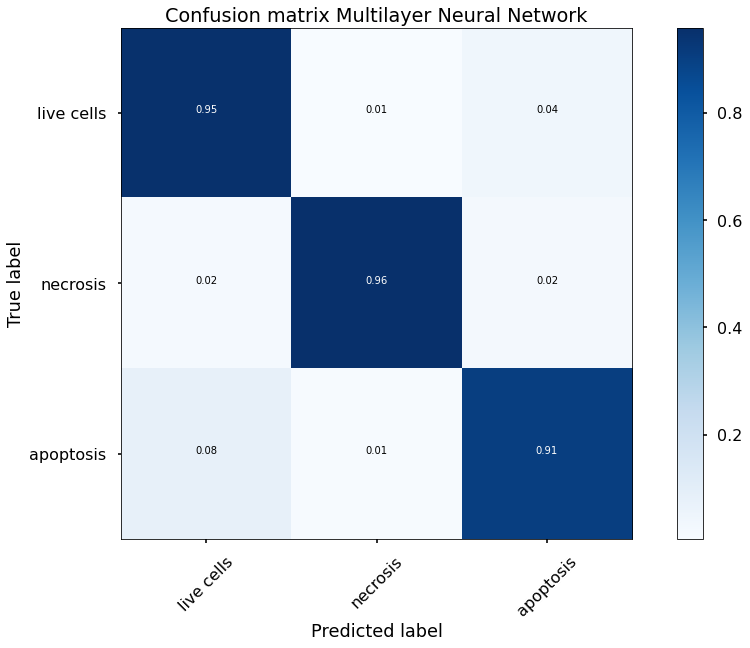

In [30]:
# Training the model
svclassifier = SVC(kernel="linear")
svclassifier.fit(X_train, y_train)
joblib.dump(svclassifier, "/content/drive/My Drive/Colab Notebooks/Small/Manuscript/Datasets/svclassifier_L_N_A.pkl")
# Predictions validation dataset
y_pred = svclassifier.predict(X_val)
cnf_matrix = sklearn.metrics.confusion_matrix(y_val,y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['live cells', 'necrosis',"apoptosis"], title='Confusion matrix Multilayer Neural Network',normalize=True)
plt.savefig("/content/drive/My Drive/Colab Notebooks/Muertes/training_confussionsvm.svg")

# TESTING (NECROSIS & APOPTOSIS)

In [31]:
#Testing dataset
dc = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Small/Manuscript/Datasets/SERS_testing.csv",index_col=0)
dc_categories = pd.DataFrame(dc.index)

#Labeling
dc_categories[dc_categories[0].str.contains("C")] = 'live cells'
dc_categories[dc_categories[0].str.contains("Ra")] = 'live cells'
dc_categories[dc_categories[0].str.contains("H2")] = 'necrosis'
dc_categories[dc_categories[0].str.contains("S")] = 'apoptosis'




dic2 = {"live cells":0,
       "necrosis":1,
        "apoptosis" :2}
  
dc_categories ["ID"] = dc_categories[0].map(dic2)


In [32]:
X_test = dc.values
y_te= dc_categories['ID'].values

Confusion matrix


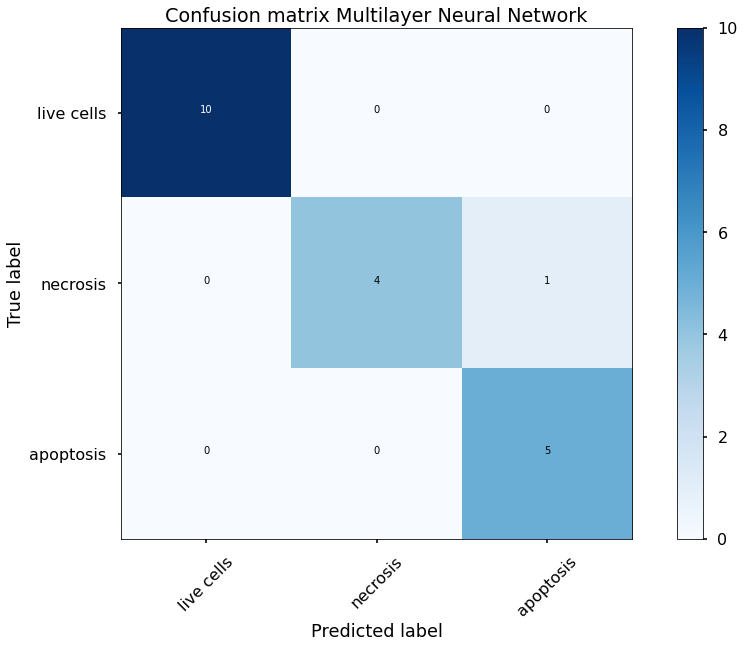

In [33]:
#Predictions testing dataset
y_pred = svclassifier.predict(X_test)
cnf_matrix = sklearn.metrics.confusion_matrix(y_te,y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['live cells', 'necrosis',"apoptosis"], title='Confusion matrix Multilayer Neural Network')
plt.savefig("/content/drive/My Drive/Colab Notebooks/Muertes/training_confussionsvm.svg")

# NEW PREDICTIONS WITH DATA COLLECTED FROM PAPER SENSORS

Introduce your datasheet with the Raman spectrum HeLa_C_1.txt, HeLa_C_2.txt, HeLa_Lysis.txt, HeLa_UV_5.txt,  HeLa_UV_10.txt,  HeLa_UV_20.txt, HeLa_UV_40.txt,  HeLa_Stau.txt, HeLa_Stau_UV_5.txt, HeLa_Stau_UV_10.txt, HeLa_Stau_UV_20.txt, HeLa_Stau_UV_40.txt 
HeLa_C_1.txt= LIVE
 HeLa_C_2.txt= LIVE
 HeLa_Lysis.txt= DEAD
 HeLa_UV_5.txt= LIVE
  HeLa_UV_10.txt= LIVE
  HeLa_UV_20.txt= DEAD
 HeLa_UV_40.txt= DEAD
  HeLa_Stau.txt= LIVE
 HeLa_Stau_UV_5.txt= DEAD
 HeLa_Stau_UV_10.txt= DEAD
 HeLa_Stau_UV_20.txt= DEAD
 HeLa_Stau_UV_40.txt = DEAD


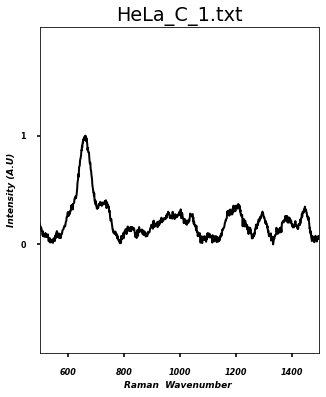

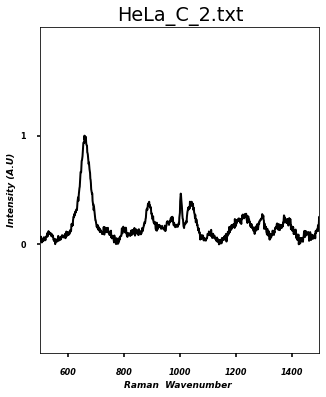

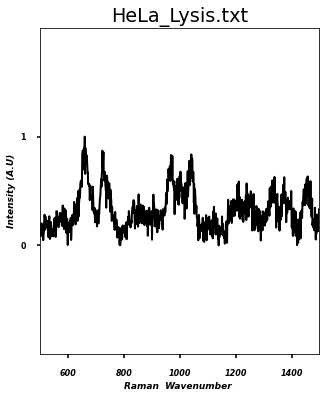

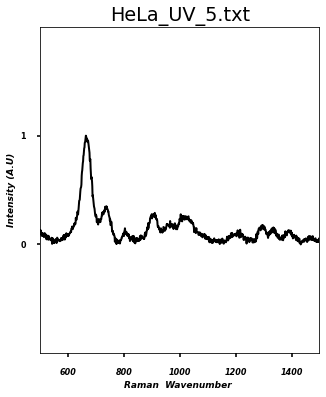

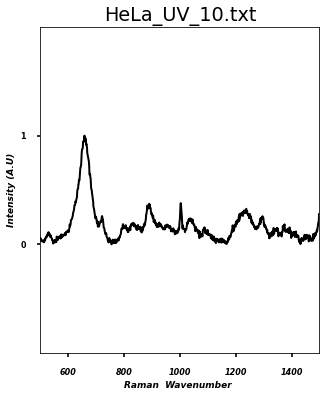

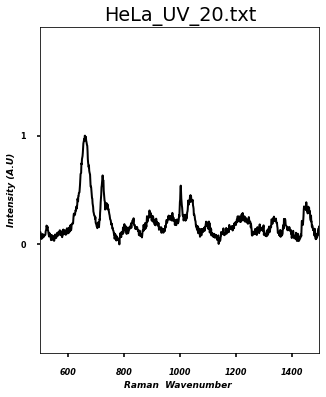

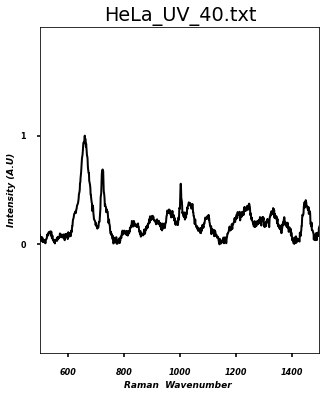

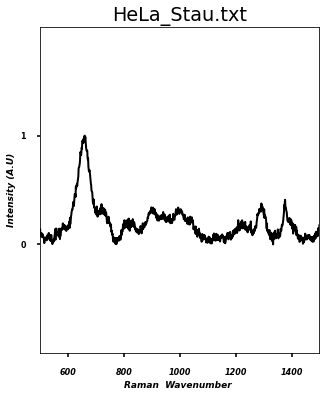

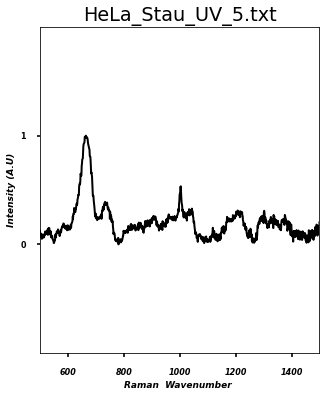

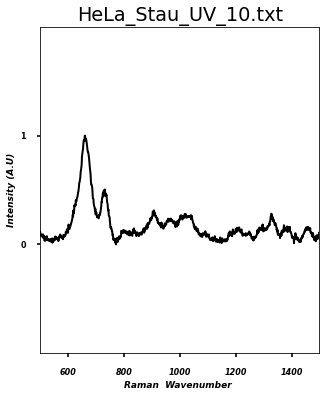

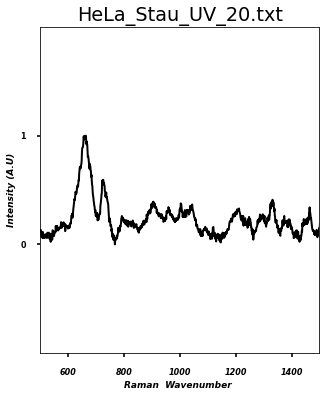

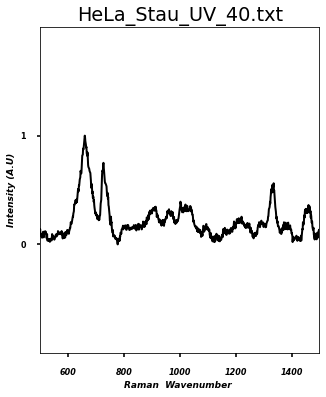

In [34]:
"""
Viability Predictions with new recorded data within idicated conditions: HeLa_C_1.txt, HeLa_C_2.txt, HeLa_Lysis.txt,
HeLa_UV_5.txt,  HeLa_UV_10.txt,  HeLa_UV_20.txt, HeLa_UV_40.txt, 
HeLa_Stau.txt, HeLa_Stau_UV_5.txt, HeLa_Stau_UV_10.txt, HeLa_Stau_UV_20.txt, HeLa_Stau_UV_40.txt   
"""
a = input("Introduce your datasheet with the Raman spectrum ")
live_dead(a)



Introduce your datasheet with the Raman spectrum PC3_C_1.txt, PC3_C_2.txt, PC3_UV_20.txt, PC3_UV_40.txt,  HT_C_1.txt, HT_C_2.txt,HT_UV_20.txt, HT_UV_40.txt
PC3_C_1.txt= LIVE
 PC3_C_2.txt= LIVE
 PC3_UV_20.txt= DEAD
 PC3_UV_40.txt= DEAD
  HT_C_1.txt= LIVE
 HT_C_2.txt= LIVE
HT_UV_20.txt= DEAD
 HT_UV_40.txt= DEAD


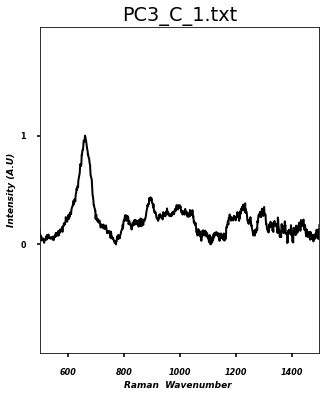

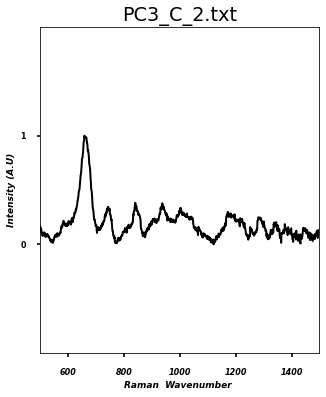

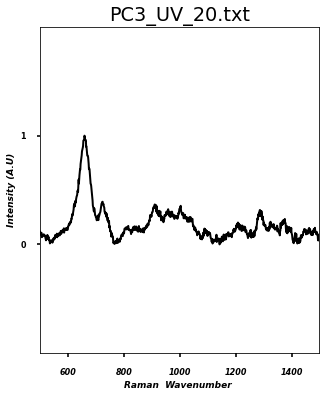

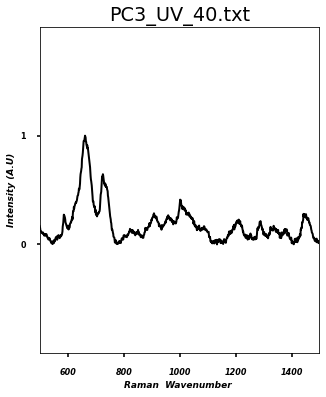

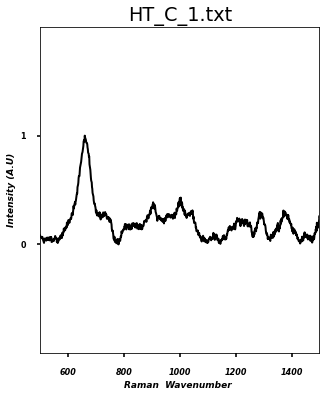

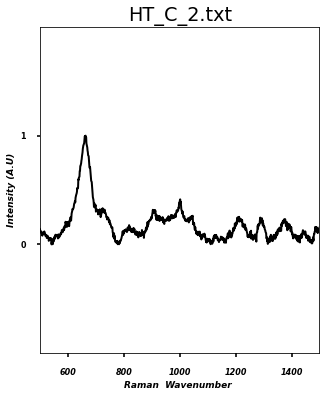

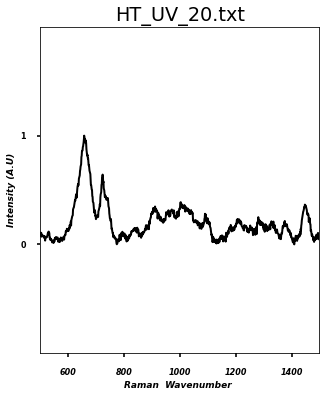

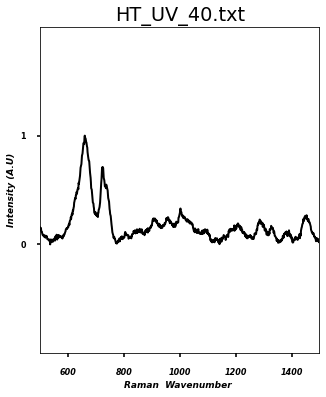

In [35]:
"""
Viability Predictions with new recorded data for other cell lines: PC3_C_1.txt, PC3_C_2.txt, PC3_UV_20.txt, PC3_UV_40.txt, 
HT_C_1.txt, HT_C_2.txt,HT_UV_20.txt, HT_UV_40.txt
"""

a = input("Introduce your datasheet with the Raman spectrum ")
live_dead(a)